In [2]:
import requests
from lxml import etree
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette(n_colors=10)

## Get data

In [ ]:
req = requests.get('https://neurips.cc/Conferences/2022/Schedule')
tree = etree.HTML(req.text)

posters = tree.findall(".//div[@class='maincard narrower poster']")
len(posters)

In [ ]:
all_information = []

for poster in tqdm(posters):
    id_ = poster.attrib['id'].split('_')[1]
    id_
    
    req = requests.get('https://neurips.cc/Conferences/2022/ScheduleMultitrack?event={}'.format(id_))
    poster_tree = etree.HTML(req.text)

    event = poster_tree.find(".//div[@class='eventName']")
    poster_title = event.text

    information = poster_tree.findall(".//div[@class='panel-body']")

    abstract = information[0].getchildren()[0].text
    authors_information = information[1].getchildren()

    authors = []
    
    for auth in authors_information:

        info = auth.getchildren()[0]

        name = info.text
        affiliation = ','.join([x.text for x in info.getchildren()]) if len(info.getchildren()) > 0 else None

        authors.append({
            'name': name,
            'affiliation': affiliation
        })
        
    all_information.append({
        'title': poster_title,
        'abstract': abstract,
        'authors': authors
    })
    
with open('neurips_statistics.json', 'w') as f:
    json.dump(all_information, f)

## Get statistics

In [3]:
with open('neurips_statistics.json', 'r') as f:
    all_information = json.load(f)

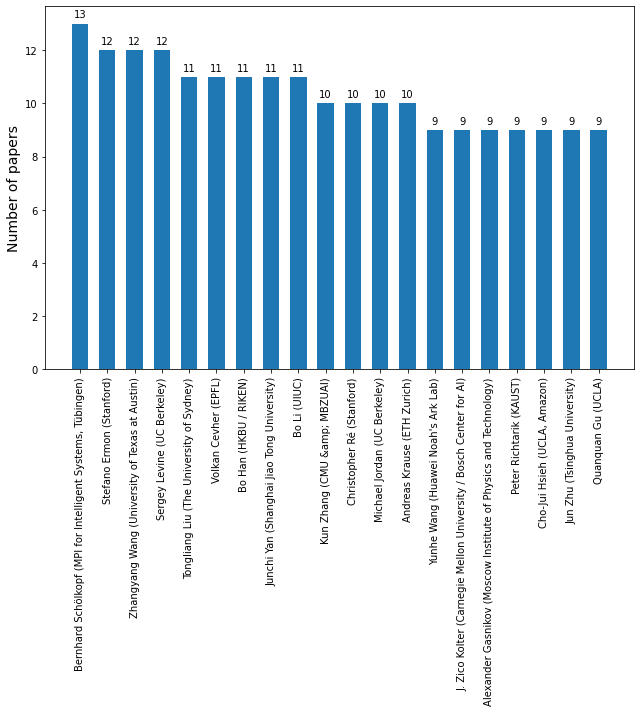

In [4]:
# Number of papers per author

papers_per_author = {}

for poster in all_information:
    for author in poster['authors']:
        name = author['name'].strip()
        affiliation = author['affiliation']
        
        id_ = '{} {}'.format(name, affiliation)

        if id_ in papers_per_author:
            papers_per_author[id_] = papers_per_author[id_] + 1
        else:
            papers_per_author[id_] = 1
            

num_authors_to_show = 20

most_popular_authors = {k: v for k, v in sorted(papers_per_author.items(), key=lambda item: -item[1])[:num_authors_to_show]}

fig = plt.figure(figsize=(9, 10))

ax = fig.add_subplot(111)

names = list(most_popular_authors.keys())
values = list(most_popular_authors.values())

bars = ax.bar(list(range(len(names))), values, color=colors[0], width = 0.6)
for p in bars.patches:
    ax.annotate(int(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

ax.set_ylabel('Number of papers', fontsize=14)
ax.set_xticks(list(range(len(names))))
ax.set_xticklabels(names, rotation=90);

plt.tight_layout()
plt.savefig('figures/authors_with_most_papers.pdf')

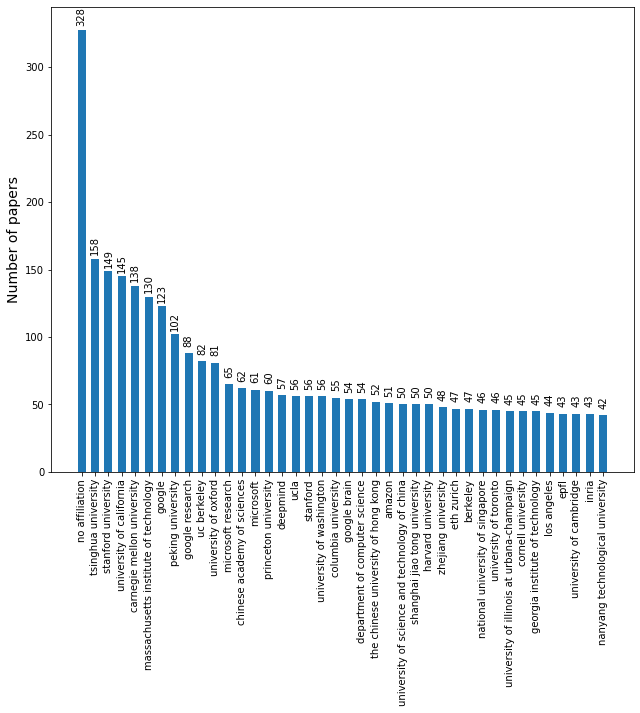

In [5]:
# Number of papers per institution

papers_per_institution = {}
mappings = {
    'cmu': 'carnegie mellon university',
    'mit': 'massachusetts institute of technology'
}

for poster in all_information:
    
    affiliations_added = set()
    
    for author in poster['authors']:
        affiliations = author['affiliation']
        
        if affiliations is None:
            affiliations = '(No Affiliation)'
        
        affiliations = affiliations[1:-1].split(',')
        for stop_word in ['&amp;', '&']:
            affiliations = [x_ for x in affiliations for x_ in x.split(stop_word)]
        
        for affiliation in affiliations:
            affiliation_clean = affiliation.strip().lower()
            affiliation_clean = affiliation_clean if affiliation_clean not in mappings else mappings[affiliation_clean]
            
            if affiliation_clean in affiliations_added:
                continue
                
            if affiliation_clean in papers_per_institution:
                papers_per_institution[affiliation_clean] = papers_per_institution[affiliation_clean] + 1
            else:
                papers_per_institution[affiliation_clean] = 1
                
            affiliations_added.add(affiliation_clean)
            
num_institutions_to_show = 40

most_popular_institutions = {k: v for k, v in sorted(papers_per_institution.items(), key=lambda item: -item[1])[:num_institutions_to_show]}

fig = plt.figure(figsize=(9, 10))
ax = fig.add_subplot(111)

names = list(most_popular_institutions.keys())
values = list(most_popular_institutions.values())

bars = ax.bar(list(range(len(names))), values, color=colors[0], width = 0.6)
for p in bars.patches:
    ax.annotate(int(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height() + 3), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), rotation=90,
                textcoords = 'offset points')

ax.set_ylabel('Number of papers', fontsize=14)
ax.set_xticks(list(range(len(names))))
ax.set_xticklabels(names, rotation=90);

plt.tight_layout()
plt.savefig('figures/institutions_with_most_papers.pdf')

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")


def add_words_to_dict(words, dic):
    for word in words:
        if word == '' or word == '-':
            continue
            
        if word in dic:
            dic[word] = dic[word] + 1
        else:
            dic[word] = 1

words_title = {}
words_abstract = {}


for poster in tqdm(all_information):
    title = poster['title']
    abstract = poster['abstract'] if poster['abstract'] is not None else ''
    
    add_words_to_dict([x.text for x in  nlp(title) if x.pos_ in ['ADJ', 'NOUN']], words_title)
    add_words_to_dict([x.text for x in  nlp(abstract) if x.pos_ in ['ADJ', 'NOUN']], words_abstract)

100%|██████████| 2906/2906 [01:12<00:00, 40.10it/s]


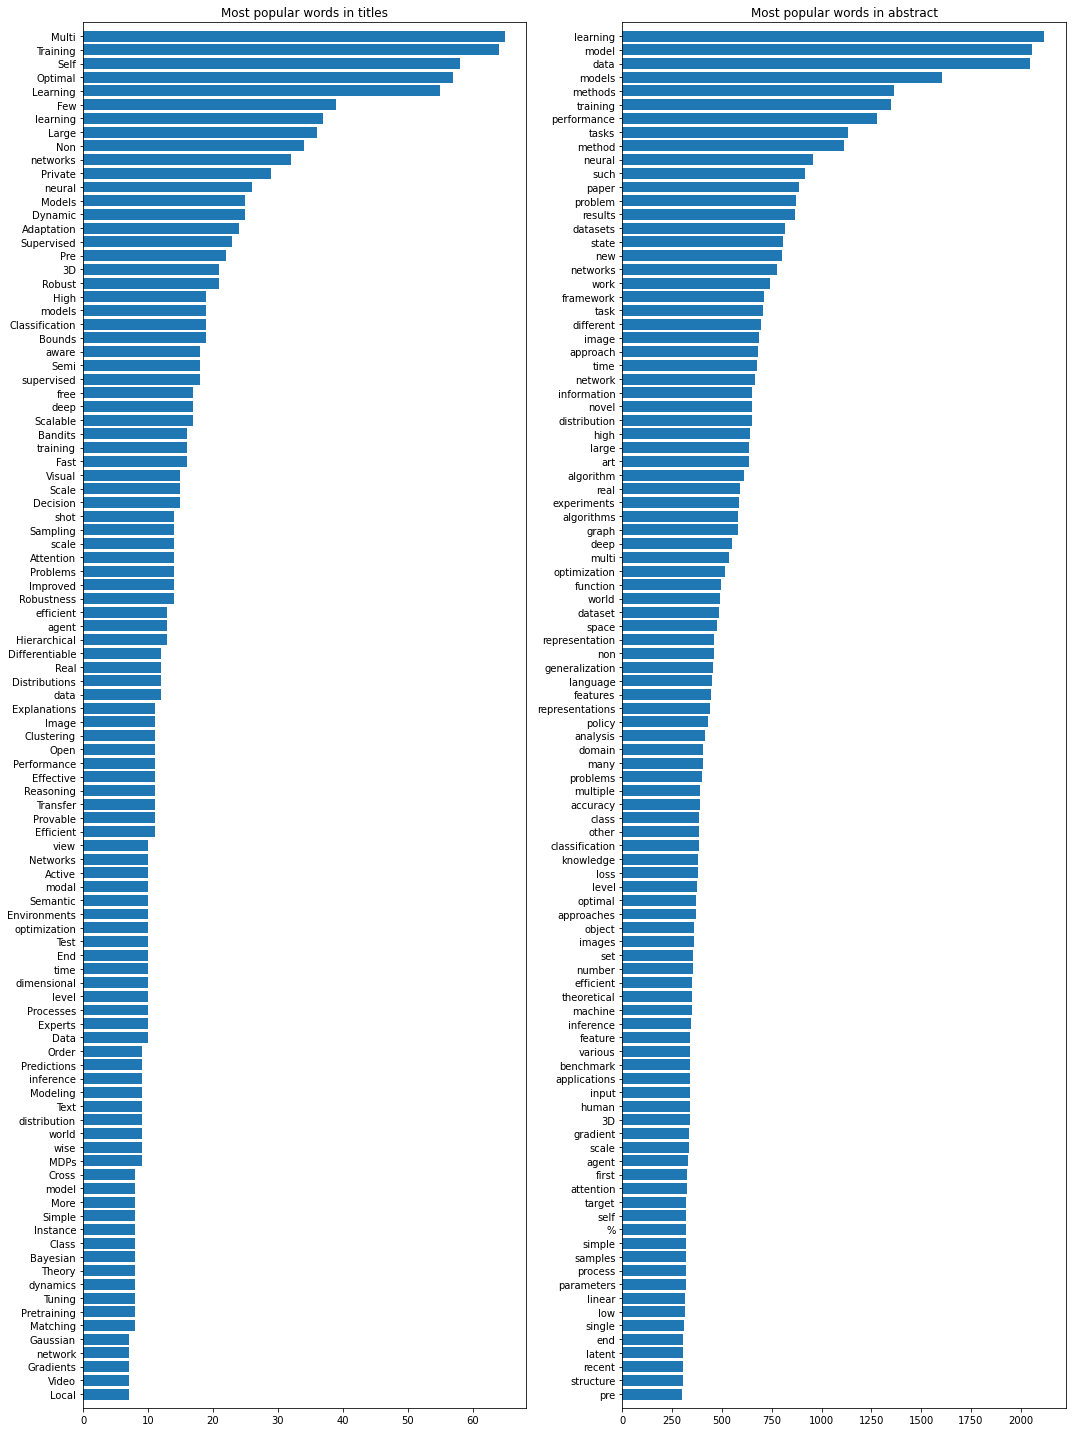

In [8]:
nums = 100

most_popular_words_titles = {k: v for k, v in sorted(words_title.items(), key=lambda item: -item[1])[:nums]}
most_popular_words_abstract = {k: v for k, v in sorted(words_abstract.items(), key=lambda item: -item[1])[:nums]}

fig = plt.figure(figsize=(15, 20))

for i, (items, title) in enumerate(zip([most_popular_words_titles, most_popular_words_abstract], ['titles', 'abstract'])):
    ax = fig.add_subplot(121 + i)

    names = list(items.keys())[::-1]
    values = list(items.values())[::-1]

    bars = ax.barh(list(range(len(names))), values)
    ax.set_ylim([-1, nums])
    ax.set_yticks(range(nums))
    ax.set_yticklabels(names);
    ax.set_title('Most popular words in {}'.format(title))

plt.tight_layout()
plt.savefig('figures/most_popular_words.pdf')